# Training Unsupervised Models
## 04_unsupervised_model_learning_lab_enc

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28.09.2025   | Adrienne | Update | Creating models |
| 05.10.2025 | Adrienne | Update | Created baseline model with KMeans |
| 07.10.2025 | Adrienne | Update | Added code for wordcloud visualization |
| 12.10.2025 | Adrienne | Update | Finshing modeling using TF-IDF encoded data 

# Content

* [Introduction](#introduction)
* [Load Data](#load-data)
* [Baseline Model](#baseline-model)

In [33]:
import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture

# dimensionality reduction methods
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
import setuptools
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

import itertools


## Introduction - Model Development

We initially label encoded our data and created a baseline KMeans model.  When running the first Kmeans model, we realized that the missings created by that feature encoding method was giving very poor results.  The model was picking up on the significant number of encoded missings and so the most important features for each component where columns for hcpcs columns that are later in the sequence that would contain more missings.  We then switched to TD-IDF encoding and got much better and useful results.  This code is in the 04_unsupervised_learning_model program and this program is show our investigation into different encoding methods.

## Load Data

In [15]:
# readin in patient level file label encoded
path = "../data/clean"
df_lab_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")

## Creating Helper Functions

In [3]:
def standardize_features(dataset):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dataset)
    return X_scaled

In [4]:
def dim_red_PCA(n_components, dataset):
    
    pca = PCA(n_components = n_components)
    X_pca = pca.fit_transform(dataset)

# Calculate the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    c_sum = np.cumsum(explained_variance_ratio) 
    pc_components = np.arange(pca.n_components_) + 1
    c_sum_df = pd.DataFrame(zip(pc_components, c_sum), columns=['Principal Component', 'Cummulative Explained Variance'])
    print(c_sum_df)
    return pca, X_pca, explained_variance_ratio, c_sum_df

In [5]:
def create_scree_plot(pca, explained_variance_ratio):
    
    pc_numbers = np.arange(pca.n_components_) + 1
    plt.figure(figsize=(3, 3)) 
    plt.plot(pc_numbers, 
            explained_variance_ratio, 
            'b.-')
    plt.title('Figure 1: Scree Plot', fontsize=8)
    plt.ylabel('Proportion of Variance', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    
    return None 

In [6]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
        
    colors = cm.jet( (labels.astype(float) ) / (n_clusters))
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        centers = model.means_
        # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        axis.scatter(c[0], c[1], 
                marker="$%d$" % i, 
                alpha=1, s=20, 
                color = cm.jet( (i ) / (n_clusters)))
        axis.set_title("K-Means Clustering Results")
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [7]:
def calculate_silhouette_score(X_pca, labels, metric):
    # works for all sklearn unsupervised model evaluation metrics with DBSCAN
    score = silhouette_score(X_pca, labels, metric= metric)
    print('Silhouetter Score: %.3f' % score)
    return score

In [8]:
def create_elbow_plot(cluster_range_start, cluster_range_end, X_pca):
    wcss = []
    for i in range(cluster_range_start, cluster_range_end):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X_pca)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(3, 3)) 
    plt.plot(range(cluster_range_start, cluster_range_end), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

## Baseline Model

Steps: 
- standardize features
- reduce features using PCA
- use Scree plot to find optimal number of components
- create KMeans model
- find optimal number of clusters using Silhouette and Elbow methods
- examine most important feature by principal component
- create graph of clusters with first two principal components
- optimize any model inputs

### KMeans using Label Encoded Data

In [16]:
# Standardize the features
X_scaled = standardize_features(df_lab_enc)

Dimensionality Reduction using Principal Component Analysis

In [17]:
# Perform PCA and calculate explained variance ratio
pca, X_pca, explained_variance_ratio, c_sum_df = dim_red_PCA(12, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.354627
1                     2                        0.558940
2                     3                        0.640050
3                     4                        0.687894
4                     5                        0.720377
5                     6                        0.744038
6                     7                        0.763254
7                     8                        0.779505
8                     9                        0.793090
9                    10                        0.803801
10                   11                        0.813990
11                   12                        0.822640


Scree Plot - to Analyze Optimal PCA Components

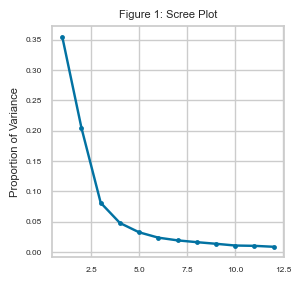

In [18]:
create_scree_plot(pca, explained_variance_ratio)

Feature Importance

In [35]:
 # creating a dataset of components so sign can be taken into account
 n_pcs= pca.components_.shape[0]
 features = df_lab_enc.columns[0:-1]
 components = [(pca.components_[i]) for i in range(n_pcs)]
 df_comp = pd.DataFrame(components, columns = features)

In [36]:
dic_imp ={}
for component in range(n_pcs):

        ser = df_comp.iloc[component, :]
        dic = dict(zip(features, ser))
        dt_importance = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))
        dt = dict(itertools.islice(dt_importance.items(), 1))
        dic_imp.update(dt)
print(dic_imp)

{'category_474_enc': 0.03589379613078482, 'category_175_enc': 0.040521428660008574, 'category_351_enc': 0.05279562718858431, 'category_53_enc': 0.05816128835483963, 'category_461_enc': 0.05830741859554979, 'hcpcs_483_enc': 0.060863038505175014, 'category_656_enc': 0.07857566808165917, 'hcpcs_478_enc': 0.06883752145669797, 'hcpcs_346_enc': 0.0668618232503481, 'category_18_enc': 0.0745073213900952, 'hcpcs_556_enc': 0.11560668519253346, 'category_17_enc': 0.0871105188247159}


Model Creation

In [23]:
# kmeans code
kmeans = KMeans(init = 'random', n_clusters=6, n_init=10, random_state = 0) 
km = kmeans.fit(X_pca) 
km.n_iter_
labels = km.labels_

# add cluster results to dataset
df_lab_enc['cluster'] = labels

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_2199/1173253025.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lab_enc['cluster'] = labels


In [24]:
# quick look at cluster values
vals = df_lab_enc['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
1,61.258151
4,23.245109
5,9.973149
2,4.372842
3,0.958957
0,0.191791


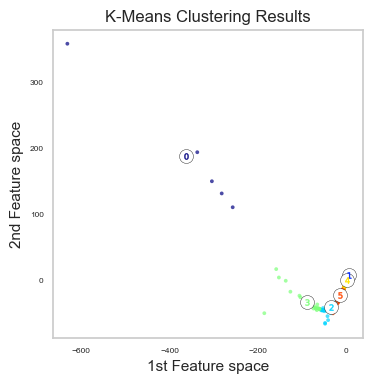

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 6, X_pca, km, ax, model_type = 'km')

### Finding Optimal Clusters

Silhouette Score

In [37]:
# works for all sklearn unsupervised model evaluation metrics with DBSCAN
sil_score = calculate_silhouette_score(X_pca, labels, 'euclidean')

Silhouetter Score: 0.526


Create a Silhouette Plot

For n_clusters = 3 The average silhouette_score is : 0.6741895329454837


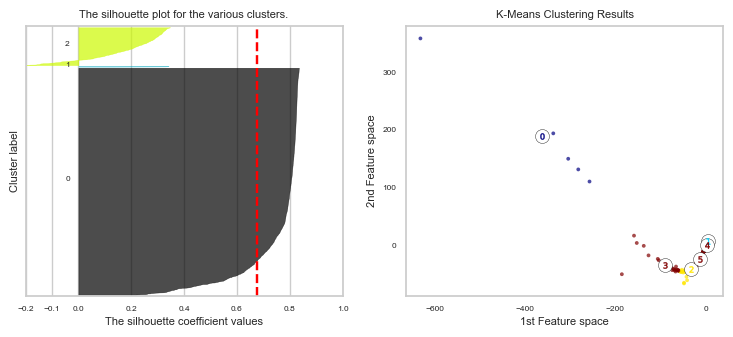

For n_clusters = 4 The average silhouette_score is : 0.6537753211834437


<Figure size 800x550 with 0 Axes>

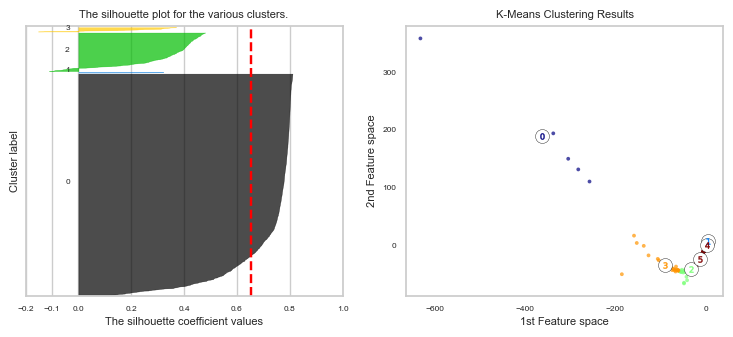

For n_clusters = 5 The average silhouette_score is : 0.6048776681274116


<Figure size 800x550 with 0 Axes>

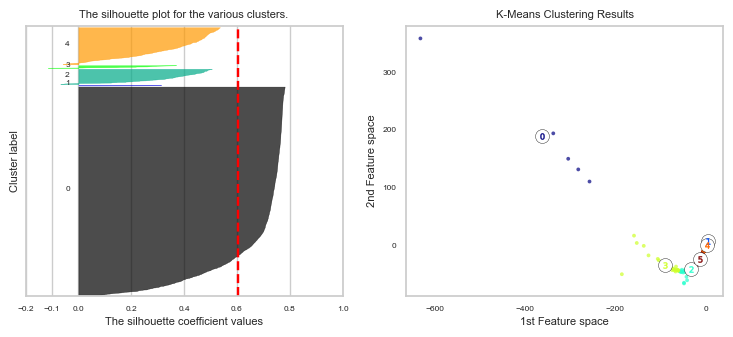

For n_clusters = 6 The average silhouette_score is : 0.6051296622135158


<Figure size 800x550 with 0 Axes>

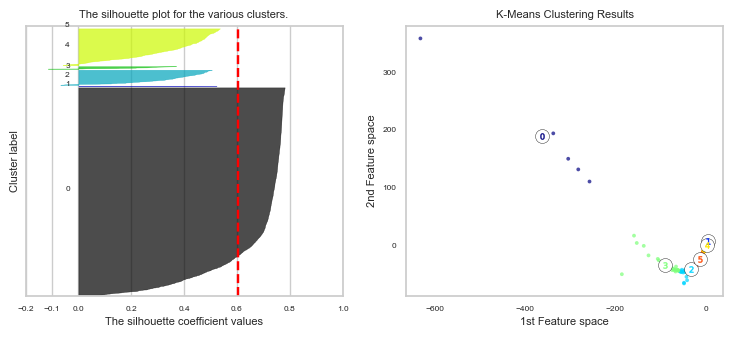

For n_clusters = 7 The average silhouette_score is : 0.5264734272301789


<Figure size 800x550 with 0 Axes>

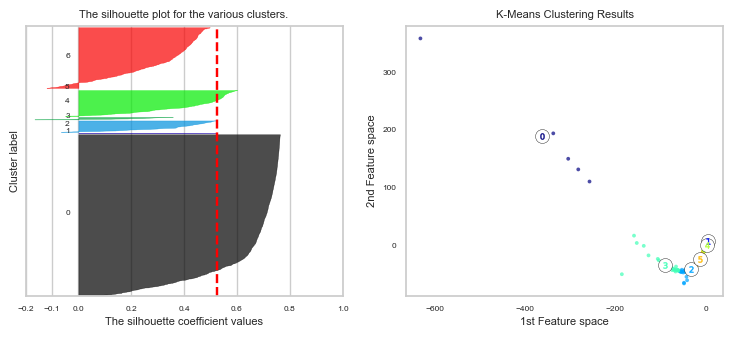

<Figure size 800x550 with 0 Axes>

In [38]:
range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:

# Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(9, 3.5))
    #fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='x', labelsize=6)

    # 2nd Plot showing the actual clusters formed
    create_cluster_plot(labels, n_clusters, X_pca, km, ax2, model_type = 'km')
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=8,
        fontweight="bold",
    )

plt.show()

Elbow Method

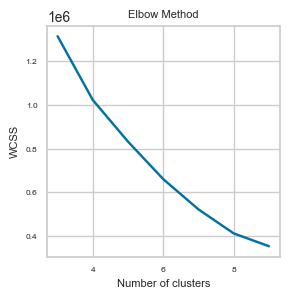

In [39]:
create_elbow_plot(3, 10, X_pca)